# Text Analytics Demo

In this demo we will showcase the powerful capabilities of the Data Ninja services by contructing a Text Analytics pipeline from scratch. By combining open source tools and packages with Data Ninja we will show you how the sematic content from unstructured data can be easily obtained and leveraged in your analytics pipeline.

We will walk through the following steps:

### 1. Fetch trending URLs

First we will scrape a news aggregation website (in this case Google News, but the idea can be extended to other news sites as well) and obtain a list of URLs that point to valid news articles.

### 2. Extract article text from URLs

We will show how the Data Ninja text extraction service can be used to identify and extract the main text from an HTML page removing all the boilerplate content (such as running headers/footers, menus, ads). 

### 3. Extract semantic content from article text

Once the text has been extracted from a webpage, we will then use another Data Ninja service to tag the article with entities and sentiment. Our content tagging system is capable of identifying the broader context of an article as we will show.

### 4. Text Analytics at Scale

We will use Apache Spark to show how to perform Text Analytics at scale. We will show how to store the Data Ninja JSON output to Hadoop HDFS and use Spark to perform some quick aggrenations.

### 5. Visualization

The insights obtained from previous stages can be communicated using a graphical visualization library. We will show a new Data Ninja app called Newsbot Ninja that brings many of these ideas together: https://newsbot.dataninja.net/

### 6. Clustering to find topics (optional)

Semantic content extracted from the text can be utilized as features and Machine Learning techniques can be used to derive isights from unstructured data. One simple example is to use a common text clustering technique like LDA to identify the topics from a collection of articles.

Let's get started!

## Demo

We will scrape a news aggregator site (Google News) to collect a list URLs that point to trending news articles. We need to remove links that are not likely to be news articles from popular media sites (such as Wikipedia or Youtube).

#### Helper methods for harvesting the links

In [1]:
from bs4 import BeautifulSoup
import requests

# Sites to exclude from our trending news URL collection
exclusions = ['google.com','youtube.com','wikipedia.org','blogspot.com']
prefix = 'http://'

def include_url(url):
    for excl in exclusions:
        if url.find(excl) > 0:
            return False
    return True

# Fetch the page content and extract the links
def fetch_links(url):
    response = requests.get(prefix + url)
    page_content = response.text
    soup = BeautifulSoup(page_content, "lxml")
    links = soup.find_all('a')
    return links

#### Collect and print the set of links

In [2]:
import os

hdfs_location = '/Users/ronaldsujithan/Projects/Current/Notebook'

linkset = set()
links = fetch_links('news.google.com')
    
# Collect the article links applying the URL filters
for link in links:
    href = link.get('href')
    if str(href).startswith(prefix) and include_url(str(href)):
        linkset.add(link.get('href').strip())
        # print str(href)
        
# Store links in HDFS
outfile = open(hdfs_location + os.path.sep + 'links' + os.path.sep + 'links.txt', "wb")
outfile.write("\n".join(linkset))

print 'Links harvested: ', str(len(linkset))

# Take 100 links for the demo
links100 = list(linkset)[:100]

Links harvested:  187


#### NoSQL integration

Next we show how to store the results from Data Ninja in a MongoDB collection

In [3]:
# Code to store data in MongoDB using PyMongo client
from pymongo import MongoClient
from bson import json_util

def connect_to_db():
    client = MongoClient('mongodb://localhost:27017/')
    db = client.dndemo
    return db.dailynews

#### Accessing the Data Ninja services

Please sign-up at https://market.mashape.com/dataninja/smart-content and obtain your free Data Ninja API key. We will access the Smart Content service to analyze the semantic content of each article obtained in the previous step. The Smart Content service is based on our pre-built knowledge graph database.

Alternatively, you can use the Amazon Web Serivices API Gateway to access our services (using your AWS account): https://auth.dataninja.net/cart

In [4]:
import json

with open('mashape_key.txt', 'r') as keyfile:
   mashape_key = keyfile.read().rstrip()
    
# Please add your own Data Ninja API Mashape key here -->
# mashape_key = <your-mashape-key>
        
smartcontent_url = 'https://smartcontent.dataninja.net/smartcontent/tag'
headers = {'Content-Type': 'application/json', 
           'Accept': 'application/json',
           'X-Mashape-User': 'Newsbot',
           'X-Mashape-Key': mashape_key}

# If you are using AWS API Gateway, please add the X-API-Key: <your-AWS-key> 
# in place of 'X-Mashape-Key': mashape_key and use the following link to access 
# the service: https://api.dataninja.net/smartcontent/tag

def fetch_smartcontent(link):
    payload = {'url': link, 'max_size': 10}
    response = requests.post(smartcontent_url, headers=headers, data=json.dumps(payload))
    return response.json()


#### Fetch Smart Content

The Smart Content service analyzes the text to produce concepts, categories, keywords and sentiments in JSON output format. Here is an example:

http://www.macrumors.com/roundup/macbook-pro/

In [5]:
data = fetch_smartcontent('http://www.macrumors.com/roundup/macbook-pro/')

# Display the JSON output from Smart Content
print json.dumps(data, indent=4)

{
    "category_list": [
        {
            "score": 2.16210563351959, 
            "category_id": 707673, 
            "category_title": "Personal computers", 
            "level": 3
        }, 
        {
            "score": 1.753662503734231, 
            "category_id": 15935563, 
            "category_title": "Mobile computers", 
            "level": 3
        }, 
        {
            "score": 1.7257233149036768, 
            "category_id": 2299258, 
            "category_title": "X86 architecture", 
            "level": 2
        }, 
        {
            "score": 1.718367963127792, 
            "category_id": 869984, 
            "category_title": "Computer architecture", 
            "level": 3
        }, 
        {
            "score": 1.560491555929184, 
            "category_id": 8633660, 
            "category_title": "X86 Macintosh computers", 
            "level": 1
        }, 
        {
            "score": 1.5422142179310323, 
            "category_id": 25734684, 
  

#### Store Smart Content output in MongoDB

Using the PyMongo client created earlier, we will show how to save the Data Ninja 
output to a MongoDB collection.

In [6]:
def write_to_db(data, db):
    return db.insert_one(json_util.loads(data)).inserted_id

In [7]:
def write_to_hdfs(data, location, filename):
    outname = location + os.path.sep + filename
    outfile = open(outname, 'w')
    outfile.write(data)
    outfile.close()
    # return hdfs.write(data, location)

#### Article Text Extraction

Built into our Smart Content Service is the ability to extract the main text from a web page using machine learning techniques. Here is an example:

In [8]:
# Dispay the extracted text from Smart Content
print data['text']

Subscribe for regular MacRumors news and future MacBook Pro info.
The New MacBook Pro with Touch Bar
Introduced on October 27, 2016, the revamped MacBook Pro is the "thinnest and lightest" Pro notebook Apple has ever made. Available in 13 and 15-inch options, the new MacBook Pro is smaller than previous models and it boasts a new "Touch Bar."
The Touch Bar is a small Retina display panel built into area above the keyboard, where the function keys used to be. The Touch Bar is like a mini computer built right into the MacBook Pro, with contextual buttons and controls that change based on what application you're using.
In Mail, for example, the Touch Bar has options for sending a reply, deleting a message, composing a new message, and more. In Messages, there are QuickType text predictions and options for choosing emoji, and in Photos, the Touch Bar can be used to scroll through and edit photos. Apple has updated all of its apps to take advantage of the Touch Bar, and third-party apps wil

#### Fetch Smart Content for a set of links

Now we will extract the Smart Content for the list of URLs we obtained from Google News earlier. We will specifically prepare a list of extracted text for topic clustering in the next step.

In [9]:
import json

# Call the Smart Content service and collect the article text into a list
documents = []

# Create a MongoDB connection
db = connect_to_db()

con_index = 0
cat_index = 0
for link in linkset:    
    data = fetch_smartcontent(link)
    if 'text' in data and len(data['text']) > 100:
        documents.append(data['text'])
        doc_id = write_to_db(json.dumps(data), db)
        if 'concept_list' in data:
            for concept in data['concept_list']:    
                write_to_hdfs(json.dumps(concept), hdfs_location + os.path.sep + 'concepts', 
                              'concept_' + str(con_index) + '.json')
                con_index += 1
        if 'category_list' in data:
            for category in data['category_list']:    
                write_to_hdfs(json.dumps(category), hdfs_location + os.path.sep + 'categories', 
                              'category_' + str(cat_index) + '.json')
                cat_index += 1        

print 'Documents in collection: ', str(len(documents))

Documents in collection:  184


#### Apache Spark Integration

We will take advantage of the many data formats Apache Spark natively supports. Recall that we stored the Concepts and Categories returned from Data Ninja in HDFS in the previous step. Here, we will show how to use PySpark to read the data into a Spark Dataframe and perform some simple aggregations to find the top-n Concepts and Categories.

In [11]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext

conf = SparkConf().setAppName('dataninja-pyspark')
sc = SparkContext(conf=conf)
sqlContext = SQLContext(sc)

def dndemo_spark():
    # A JSON dataset in HDFS.
    # The path can be either a single text file or a directory storing text files.
    concepts = sqlContext.read.json(hdfs_location + os.path.sep + 'concepts')
    concepts.printSchema()
    concepts.registerTempTable('concepts')
    
    categories = sqlContext.read.json(hdfs_location + os.path.sep + 'categories')
    categories.printSchema()
    categories.registerTempTable('categories')

# Run this only once!
# You can only have once SparkContext and SqlContext
dndemo_spark()    

root
 |-- concept_id: long (nullable = true)
 |-- concept_title: string (nullable = true)
 |-- score: double (nullable = true)

root
 |-- category_id: long (nullable = true)
 |-- category_title: string (nullable = true)
 |-- level: long (nullable = true)
 |-- score: double (nullable = true)



In [18]:
count = sqlContext.sql('SELECT count(*) as num_concepts FROM concepts')
print count.show()

count = sqlContext.sql('SELECT count(*) as num_categories FROM categories')
print count.show()

trending_con = sqlContext.sql('SELECT concept_title, sum(score) as total_score ' +
                              'FROM concepts GROUP BY concept_title ORDER BY total_score desc')

trending_cat = sqlContext.sql('SELECT category_title, sum(score) as total_score ' +
                              'FROM categories GROUP BY category_title ORDER BY total_score desc')

# print trending.show()

+------------+
|num_concepts|
+------------+
|        1163|
+------------+

None
+--------------+
|num_categories|
+--------------+
|          1890|
+--------------+

None


#### Visualizing the results

We will convert the final results from Spark Dataframe to a Pandas Dataframe and visualize the trending Concepts and Categories.

In [19]:
from IPython.display import display, HTML
from tabulate import tabulate
import pandas as pd

display(trending_con)
display(trending_cat)

df_con = trending_con.toPandas().head(n=40)
df_cat = trending_cat.toPandas().head(n=40)

print 'Top 40 trending concepts:'
print tabulate(df_con)

print 'Top 40 trending categories'
print tabulate(df_cat)


DataFrame[concept_title: string, total_score: double]

DataFrame[category_title: string, total_score: double]

Top 40 trending concepts:
--  --------------------------------------------------------  --------
 0  Bollea v. Gawker                                          2.70546
 1  Gawker Media                                              2.4591
 2  Beauty and the Beast (2017 film)                          2.35367
 3  Gawker                                                    2.21464
 4  Beauty and the Beast (Disney franchise)                   2.06185
 5  Hong Kong LegCo members' oath-taking controversy          2.00179
 6  People v. Turner                                          1.94769
 7  Brine pool                                                1.63426
 8  Malaysia Airlines Flight 370                              1.47935
 9  Hillary Clinton email controversy                         1.46541
10  Donald Trump and Billy Bush recording controversy         1.45322
11  James Webb Space Telescope                                1.40214
12  Hubble Space Telescope                                    1.

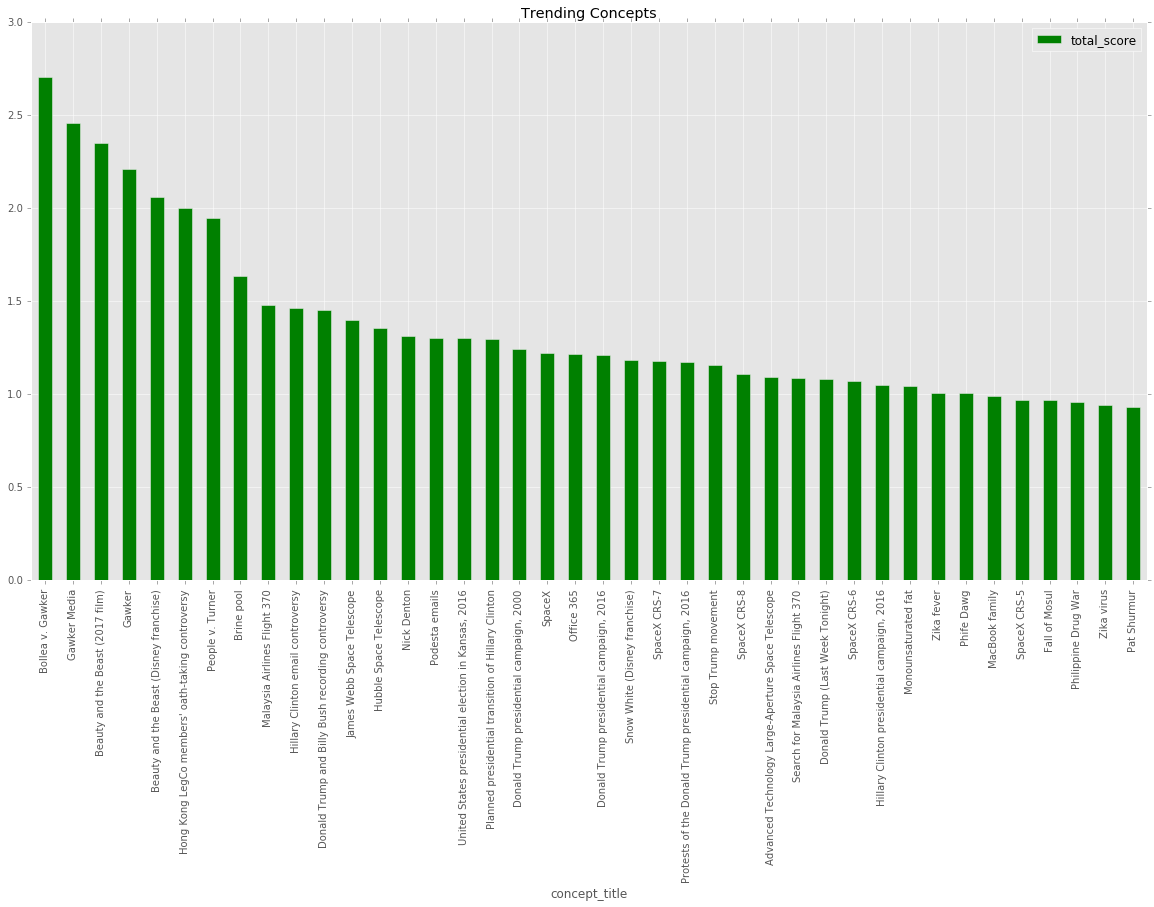

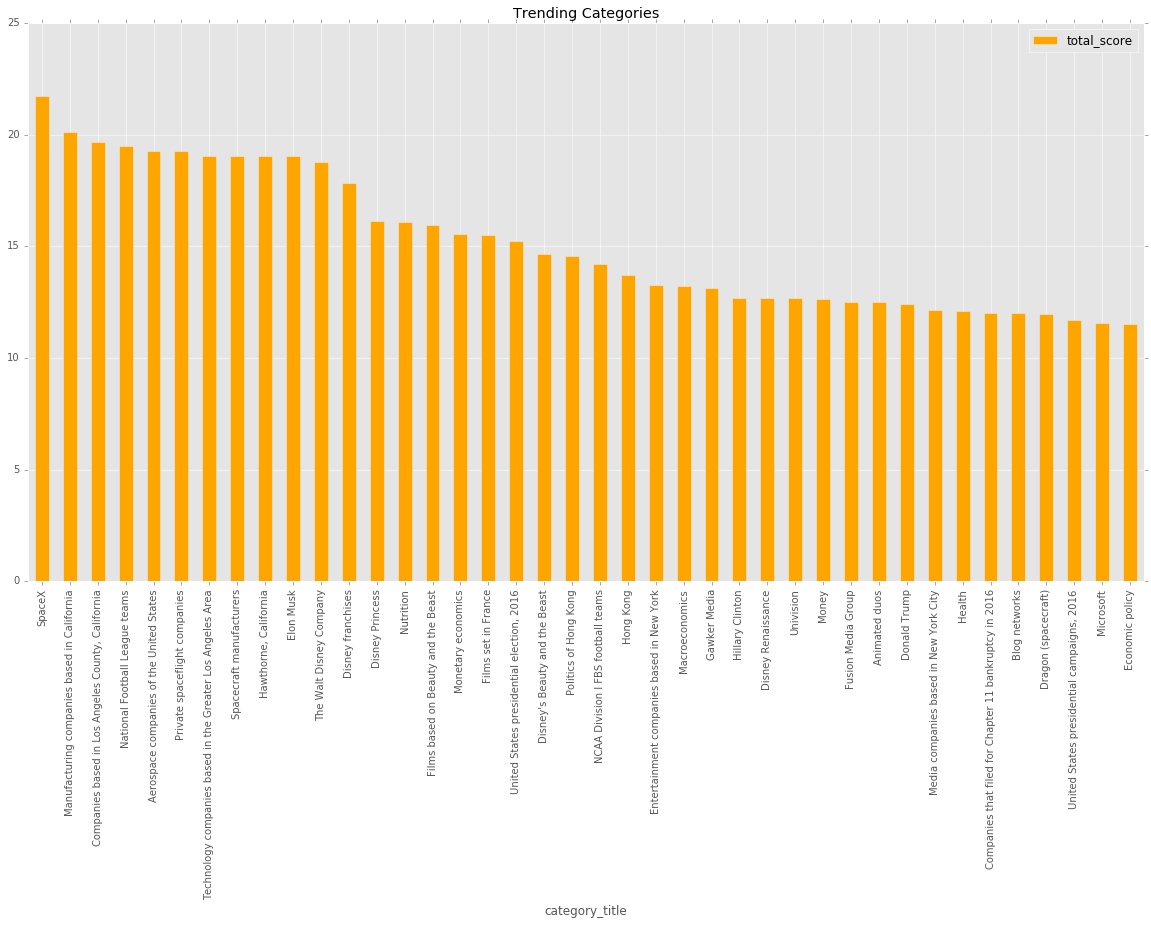

In [21]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline 

df_con.plot(x='concept_title', y='total_score', kind='bar', title='Trending Concepts', color='green', figsize=(20,10))
df_cat.plot(x='category_title', y='total_score', kind='bar', title='Trending Categories', color='orange', figsize=(20,10))
